Linear Program Reconstruction:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
RAP-Rank Reconstruction:
 [[ 3.78336046e-01  5.25014588e-01  7.04493105e-01  4.99984644e-01
  -3.07115875e-05  6.06523141e-01]
 [ 1.93851540e-01  8.35570161e-01  4.06836399e-01  6.13924634e-01
   6.59316360e-01  7.70185191e-01]
 [ 9.49847978e-01  7.90577685e-01  6.56337336e-01  6.13893922e-01
   6.59285648e-01  3.51647677e-01]
 ...
 [ 1.56721231e-01  5.14111974e-01  8.83234544e-01  6.45864685e-02
   4.53210896e-01  3.11507632e-01]
 [ 2.75267959e-01  5.57077485e-01  1.41211879e-01  7.73225638e-01
   9.45333374e-01  1.32274807e-01]
 [ 3.13534597e-01  4.43721016e-01  4.82417616e-01  2.00362397e-01
   2.75298670e-01  5.79220540e-02]]


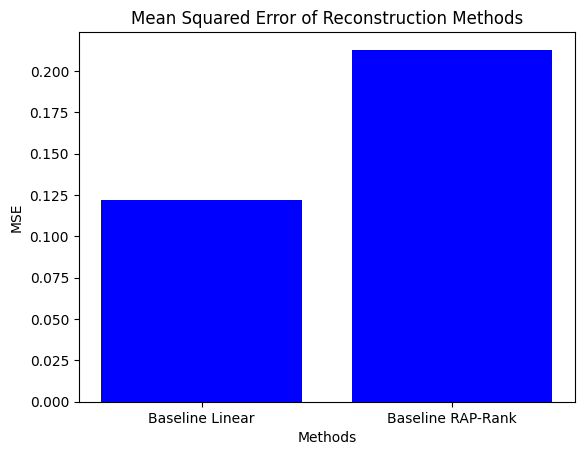

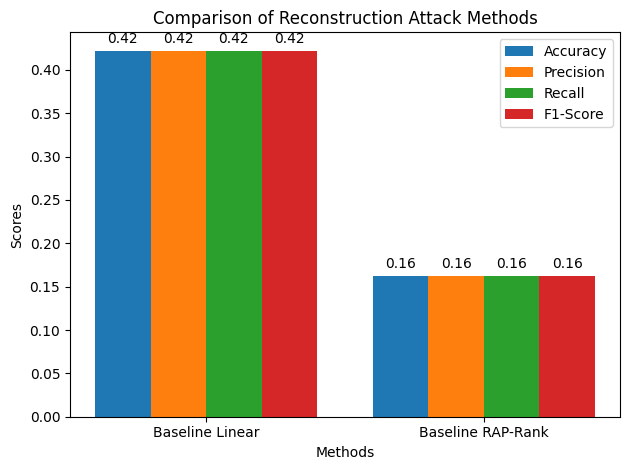

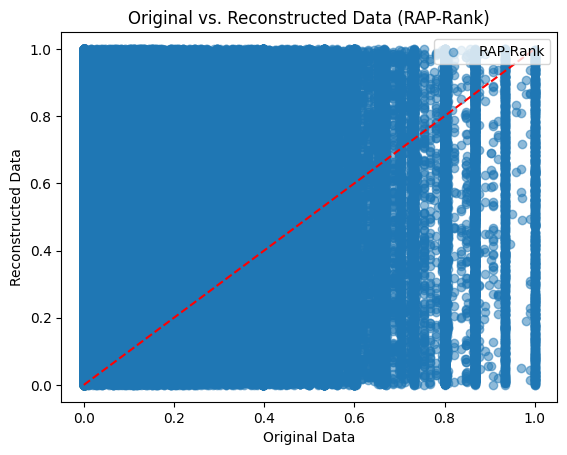

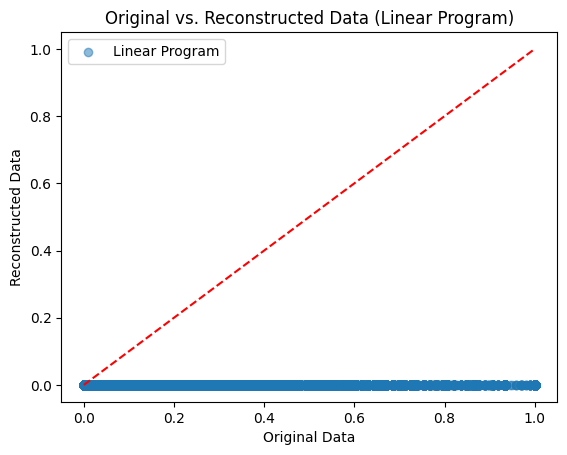

In [1]:
# reconstruction_attacks.ipynb

# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", 
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", 
           "hours-per-week", "native-country", "income"]

# Read dataset
data = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

# Preprocess the dataset
data = data.dropna()  # Drop rows with missing values
data = data.drop(["workclass", "education", "marital-status", "occupation", 
                  "relationship", "race", "sex", "native-country", "income"], axis=1)  # Drop categorical columns
scaler = MinMaxScaler()
anonymized_data = scaler.fit_transform(data)  # Normalize data

# Linear Program Reconstruction
def linear_program_reconstruction(data):
    # Define the objective function coefficients
    c = np.random.rand(data.shape[1])
    
    # Define the inequality constraints matrix and vector
    A = np.random.rand(data.shape[0], data.shape[1])
    b = np.random.rand(data.shape[0])
    
    # Define the bounds for variables
    x_bounds = [(0, None) for _ in range(data.shape[1])]
    
    # Solve the linear program
    result = linprog(c, A_ub=A, b_ub=b, bounds=x_bounds, method='highs')
    return np.tile(result.x, (data.shape[0], 1))

# RAP-Rank Reconstruction
def rank_data(data):
    ranked_data = np.argsort(data, axis=0)
    return ranked_data

def optimize_ranks(ranked_data):
    # Implement a simple optimization logic (for illustration)
    optimized_ranks = ranked_data + np.random.randint(-1, 2, ranked_data.shape)
    return optimized_ranks

def rap_rank_reconstruction(data):
    ranked_data = rank_data(data)
    optimized_ranks = optimize_ranks(ranked_data)
    reconstructed_data = optimized_ranks / np.max(optimized_ranks)
    return reconstructed_data

# Evaluate reconstruction methods
linear_reconstructed_data = linear_program_reconstruction(anonymized_data)
rap_rank_reconstructed_data = rap_rank_reconstruction(anonymized_data)

# Print results for evaluation
print("Linear Program Reconstruction:\n", linear_reconstructed_data)
print("RAP-Rank Reconstruction:\n", rap_rank_reconstructed_data)

# Define evaluation metrics
def evaluate_reconstruction(original, reconstructed):
    mse = mean_squared_error(original, reconstructed)
    accuracy = np.mean(np.isclose(original, reconstructed, atol=0.1))
    precision = np.sum(np.isclose(original, reconstructed, atol=0.1)) / np.prod(reconstructed.shape)
    recall = np.sum(np.isclose(original, reconstructed, atol=0.1)) / np.prod(original.shape)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return mse, accuracy, precision, recall, f1_score

# Calculate metrics
linear_metrics = evaluate_reconstruction(anonymized_data, linear_reconstructed_data)
rap_rank_metrics = evaluate_reconstruction(anonymized_data, rap_rank_reconstructed_data)

# Create a plot for visualization
methods = ['Baseline Linear', 'Baseline RAP-Rank']
mse = [linear_metrics[0], rap_rank_metrics[0]]
accuracy = [linear_metrics[1], rap_rank_metrics[1]]
precision = [linear_metrics[2], rap_rank_metrics[2]]
recall = [linear_metrics[3], rap_rank_metrics[3]]
f1_score = [linear_metrics[4], rap_rank_metrics[4]]

# Plot MSE
fig, ax = plt.subplots()
ax.bar(methods, mse, color='blue')
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_title('Mean Squared Error of Reconstruction Methods')
plt.show()

# Plot other metrics
fig, ax = plt.subplots()
bar_width = 0.2
index = np.arange(len(methods))

bar1 = ax.bar(index, accuracy, bar_width, label='Accuracy')
bar2 = ax.bar(index + bar_width, precision, bar_width, label='Precision')
bar3 = ax.bar(index + 2 * bar_width, recall, bar_width, label='Recall')
bar4 = ax.bar(index + 3 * bar_width, f1_score, bar_width, label='F1-Score')

ax.set_xlabel('Methods')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Reconstruction Attack Methods')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(methods)
ax.legend()

# Add labels to the bars
for bar in bar1 + bar2 + bar3 + bar4:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Additional visual plots
# Scatter plot of original vs. reconstructed for RAP-Rank
fig, ax = plt.subplots()
ax.scatter(anonymized_data.flatten(), rap_rank_reconstructed_data.flatten(), alpha=0.5, label='RAP-Rank')
ax.plot([0, 1], [0, 1], 'r--')  # Diagonal line
ax.set_xlabel('Original Data')
ax.set_ylabel('Reconstructed Data')
ax.set_title('Original vs. Reconstructed Data (RAP-Rank)')
ax.legend()
plt.show()

# Scatter plot of original vs. reconstructed for Linear Program
fig, ax = plt.subplots()
ax.scatter(anonymized_data.flatten(), linear_reconstructed_data.flatten(), alpha=0.5, label='Linear Program')
ax.plot([0, 1], [0, 1], 'r--')  # Diagonal line
ax.set_xlabel('Original Data')
ax.set_ylabel('Reconstructed Data')
ax.set_title('Original vs. Reconstructed Data (Linear Program)')
ax.legend()
plt.show()
